In [234]:
import networkx as nx
import numpy as np
from sklearn.neighbors import KDTree
import base
from importlib import reload
import matplotlib.pyplot as plt

import base

In [417]:
def create_line(start, end, num_points):
    '''
    Returns points on a line between start, end. (Including start, excluding end)
    '''
    if num_points <= 1:
        return np.array(start).reshape(-1,len(start))
    
    v = np.array(end)-np.array(start)
    points = []
    for i in range(int(num_points)):
        s = i / float(num_points)
        points.append(start + s*v)
        
    return  np.vstack(points)


def create_square(length, height, grid_size):
    corners = [(-length/2.0, -length/2.0, height),
              (-length/2.0, length/2.0, height),
              (length/2.0, length/2.0, height),
              (length/2.0, -length/2.0, height)]
    points = np.empty((0,3))
    for i in range(4):
        start = corners[i]
        end = corners[(i+1)%4]
        line = create_line(start, end, num_points=int(length/grid_size))
        points = np.vstack([points, line])
    return points
    

def create_pyramid(ground_length, height, grid_size):
    points = np.empty((0,3))
    
    # Ground
    coords = np.linspace(-ground_length/2.0,ground_length/2.0,ground_length/float(grid_size))
    ground_x, ground_y, ground_z = np.meshgrid(coords,coords,[0.0])
    ground = np.vstack([ground_x.flatten(), ground_y.flatten(), ground_z.flatten()]).T
    points = ground
    
    # Triangles
    for f in np.linspace(float(grid_size)/height,1.0,height/float(grid_size)):
        crt_height = f * height
        crt_length = (1-f)*ground_length
        square = create_square(crt_length, crt_height, grid_size)
        points = np.vstack([points, square])
    return points
    
    
def create_cube(edge_length, grid_size):
    points = np.empty((0,3))
    
    # Ground
    coords = np.linspace(-edge_length/2.0,edge_length/2.0,edge_length/float(grid_size))
    ground_x, ground_y, ground_z = np.meshgrid(coords,coords,[0.0])
    ground = np.vstack([ground_x.flatten(), ground_y.flatten(), ground_z.flatten()]).T
    points = ground
    
    # Squares in the middle
    f_low = float(grid_size)/edge_length
    f_high = 1.0-float(grid_size)/edge_length
    for f in np.linspace(f_low, f_high, edge_length/float(grid_size)-2):
        crt_height = f * edge_length
        square = create_square(edge_length, crt_height, grid_size)
        points = np.vstack([points, square])
    
    # Top
    coords = np.linspace(-edge_length/2.0,edge_length/2.0,edge_length/float(grid_size))
    ground_x, ground_y, ground_z = np.meshgrid(coords,coords,[float(edge_length)])
    ground = np.vstack([ground_x.flatten(), ground_y.flatten(), ground_z.flatten()]).T
    points = np.vstack([points, ground])
    return  points

### Pyramid

<IPython.core.display.Javascript object>


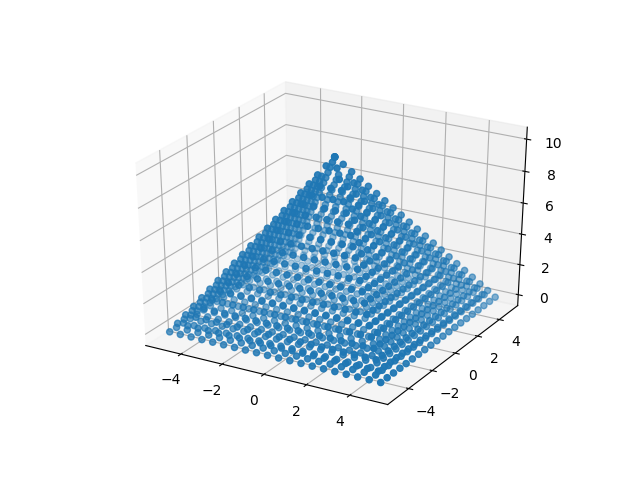

In [396]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pyramid = create_pyramid(ground_length=10,height=10,grid_size=0.5)
pyramid += 0.001*np.random.randn(*pyramid.shape)
ax.scatter(pyramid[:,0],pyramid[:,1],pyramid[:,2])

In [406]:
MG = base.Meshgrid(pyramid)
diag = np.linalg.norm(np.min(pyramid,axis=0) - np.max(pyramid,axis=0))
max_dist = 0.1*diag
#print('Max_dist:',max_dist)
#MG.compute_all_harris_responses(neigh_flag='ring', neigh_args={'max_dist':max_dist})
MG.compute_all_harris_responses(neigh_flag='k', neigh_args={'k':10}, k_harris=0.04)
harris_values = MG.harris_values

In [398]:
np.max(harris_values)

28.33685036119665

<IPython.core.display.Javascript object>


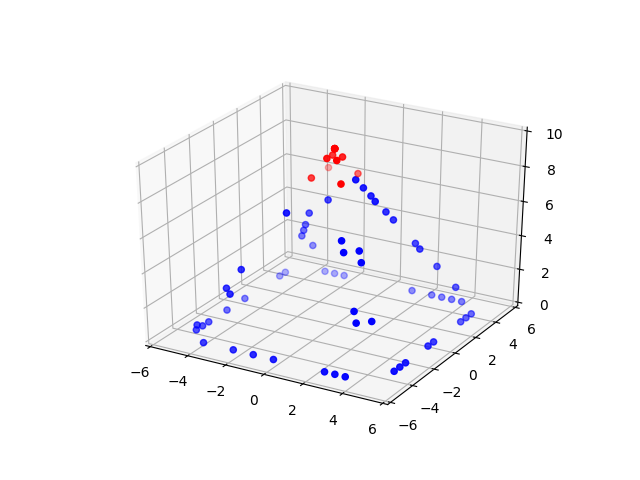

(0, 10)

In [405]:
indices_smallest = np.argsort(harris_values)[int(0.0*len(harris_values)):int(0.05*len(harris_values))]
indices_largest = np.argsort(harris_values)[int(0.99*len(harris_values)):int(1.0*len(harris_values))]
pyramid_smallest = pyramid[indices_smallest]
pyramid_largest = pyramid[indices_largest]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pyramid_smallest[:,0],pyramid_smallest[:,1],pyramid_smallest[:,2],c='b')
ax.scatter(pyramid_largest[:,0],pyramid_largest[:,1],pyramid_largest[:,2],c='r')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(-0,10)

<IPython.core.display.Javascript object>


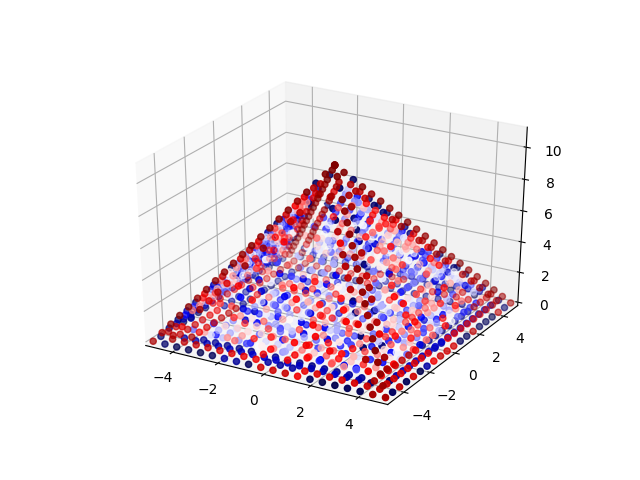

(0, 11)

In [341]:
indices = np.argsort(harris_values)[int(0*len(harris_values)):int(1.0*len(harris_values))]
pyramid_new = pyramid[indices]
harris_new = harris_values[indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pyramid_new[:,0],pyramid_new[:,1],pyramid_new[:,2],c=np.linspace(0,1,len(pyramid_new)),cmap='seismic')
#ax.scatter(pyramid_new[:,0],pyramid_new[:,1],pyramid_new[:,2],c=harris_new,cmap='seismic')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-0,11)


### Cube

<IPython.core.display.Javascript object>


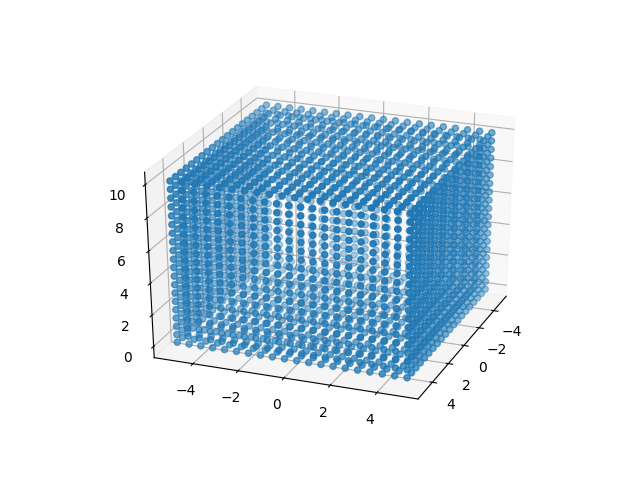

6720 points


In [430]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cube = create_cube(edge_length=10,grid_size=0.5)
cube += 0.001*np.random.randn(*cube.shape)
ax.scatter(cube[:,0],cube[:,1],cube[:,2])
print(cube.size,'points')

In [431]:
MG = base.Meshgrid(cube)
diag = np.linalg.norm(np.min(cube,axis=0) - np.max(cube,axis=0))
max_dist = 0.1*diag
#print('Max_dist:',max_dist)
#MG.compute_all_harris_responses(neigh_flag='ring', neigh_args={'max_dist':max_dist})
MG.compute_all_harris_responses(neigh_flag='k', neigh_args={'k':50}, k_harris=0.04)
harris_values = MG.harris_values
print('min harris   ',np.min(harris_values))
print('median harris',np.median(harris_values))
print('max harris   ',np.max(harris_values))

min harris    -0.06802239203123063
median harris 1.1883602972718902e-16
max harris    0.19381828447122415


<IPython.core.display.Javascript object>


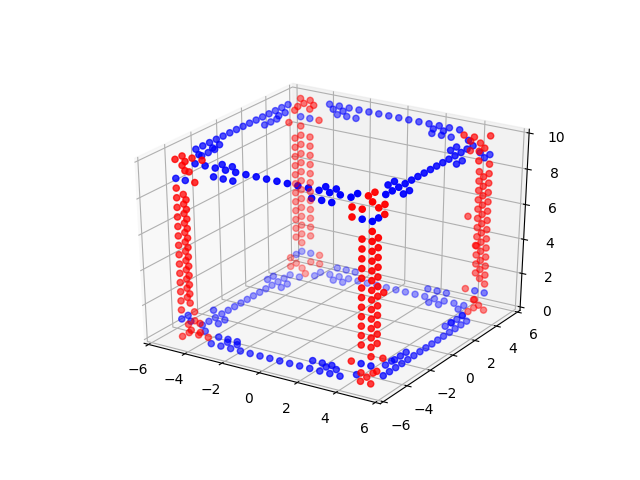

(0, 10)

In [436]:
indices_smallest = np.argsort(harris_values)[int(0.0*len(harris_values)):int(0.1*len(harris_values))]
indices_largest = np.argsort(harris_values)[int(0.9*len(harris_values)):int(1.0*len(harris_values))]
cube_smallest = cube[indices_smallest]
cube_largest = cube[indices_largest]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_smallest[:,0],cube_smallest[:,1],cube_smallest[:,2],c='b')
ax.scatter(cube_largest[:,0],cube_largest[:,1],cube_largest[:,2],c='r')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

<IPython.core.display.Javascript object>


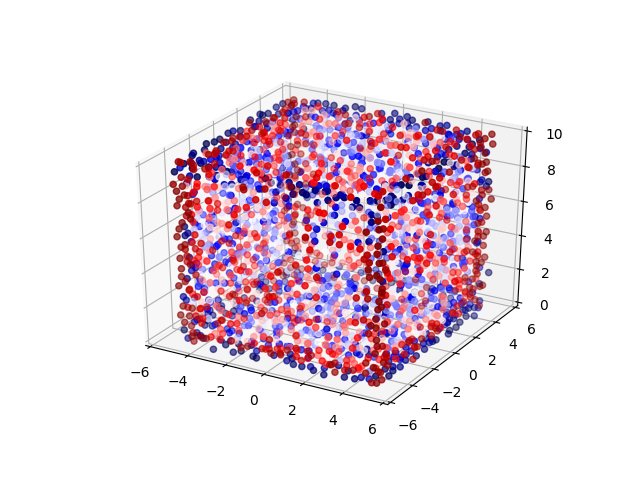

(0, 10)

In [428]:
indices = np.argsort(harris_values)[int(0*len(harris_values)):int(1.0*len(harris_values))]
cube_new = cube[indices]
harris_new = harris_values[indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_new[:,0],cube_new[:,1],cube_new[:,2],c=np.linspace(0,1,len(cube_new)),cmap='seismic')
#ax.scatter(cube_new[:,0],cube_new[:,1],cube_new[:,2],c=harris_new,cmap='seismic')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)
